In [62]:
import pandas as pd
from io import BytesIO
import requests
import numpy as np
import json
from urllib.parse import urlencode
import seaborn as sns
import matplotlib.pyplot as plt

import pandahouse as ph

In [2]:
connection_default = {'host': 'https://clickhouse.lab.karpov.courses',
                      'database':'default',
                      'user':'student', 
                      'password':'dpo_python_2020'
                     }

Выгрузите из таблицы данные о цене в зависимости от типа жилья. Необходимые столбцы:

price – цена за ночь
room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
Ограничение поставьте на 1000 строк. Результат должен быть отсортирован по возрастанию id.

Пример результирующей таблицы:

+-----------------+------------+
| room_type       | price      |
+-----------------+------------+
| Private room    |         65 | 
| Entire home/apt |        100 | 
+-----------------+------------+
Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн [$,] чтобы избавиться от $ и запятых; toFloat32OrNull(столбец)

Сгруппируйте полученный датафрейм по типу жилья и посчитайте 75-й перцентиль цены.

В качестве ответа впишите полученное значение 75 перцентиля цены для комнат типа Private room.

In [16]:
q = '''
SELECT
toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) as price,
room_type
FROM
ldn_listings
order by id
LIMIT 1000
'''

In [17]:
q_test = ph.read_clickhouse(query=q, connection=connection_default)
q_test

,price,room_type
0,65.0,Private room
1,100.0,Entire home/apt
2,300.0,Entire home/apt
3,150.0,Private room
4,65.0,Entire home/apt
...,...,...
995,110.0,Entire home/apt
996,110.0,Entire home/apt
997,65.0,Private room
998,100.0,Entire home/apt


In [20]:
q_test.groupby('room_type').quantile(q=0.75)

,price
room_type,
Entire home/apt,160.00
Hotel room,157.00
Private room,70.00
Shared room,69.25


К данным о цене и типе комнаты дополнительно выгрузите данные о рейтинге жилья (review_scores_rating). В запросе необходимо будет отфильтровать пустые значения review_scores_rating и сконвертировать эту колонку в тип float32.

Hint: toFloat32OrNull(столбец)

Давайте построим график рассеивания, который покажет зависимость средней оценки от средней цены по типу жилья.

Исходная таблица должна выглядеть так:

+-----------------+------------+--------------------+
| room_type       | price      |review_scores_rating|
+-----------------+------------+--------------------+
| Private room    |         65 | 96.0               |
| Entire home/apt |        100 | 78.0               |
+-----------------+------------+--------------------+
1) сгруппируйте датафрейм по типу жилья и посчитайте среднее для цены и рейтинга (не забудьте привести рейтинг к типу float)

2) используйте sns.scatterplot, чтобы построить график рассеивания средней цены (ось X) и рейтинга (ось Y) c разбивкой по типу жилья (параметр hue)

In [22]:
w = '''
SELECT
toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) as price,
toFloat32OrNull(review_scores_rating) as scores_rating,
room_type
FROM
ldn_listings
where toFloat32OrNull(review_scores_rating) is not null
order by id
LIMIT 1000
'''

In [33]:
w_test = ph.read_clickhouse(query=w, connection=connection_default)
w_test

,price,scores_rating,room_type
0,65.0,97.0,Private room
1,100.0,96.0,Entire home/apt
2,300.0,94.0,Entire home/apt
3,65.0,93.0,Entire home/apt
4,29.0,96.0,Private room
...,...,...,...
995,165.0,100.0,Entire home/apt
996,99.0,93.0,Private room
997,45.0,100.0,Private room
998,20.0,88.0,Private room


In [34]:
w_test = w_test.groupby('room_type', as_index=False) \
    .agg({'price':'mean', 'scores_rating':'mean'})

In [35]:
w_test

,room_type,price,scores_rating
0,Entire home/apt,135.882950,93.568787
1,Hotel room,134.000000,92.500000
2,Private room,54.642437,94.766205
3,Shared room,21.000000,90.000000


<Axes: xlabel='price', ylabel='scores_rating'>

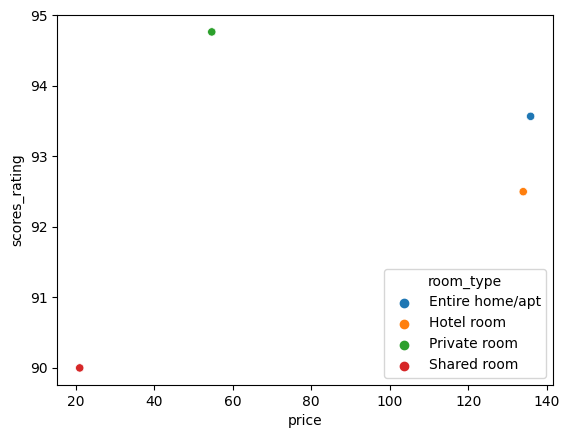

In [37]:
sns.scatterplot(data=w_test, x='price', y='scores_rating', hue='room_type') 

Итак, помимо аренды жилья, на Airbnb также есть "Впечатления" — мероприятия, которые организуют местные жители.

Проверим, какие способы верификации аккаунта использовали хозяева, предлагающие различные впечатления (experiences_offered != 'none'). Для каждого уникального пользователя выгрузите только две колонки:

host_id – идентификатор хозяина (уникальный)
host_verifications – какими способами хост подтвердил свой профиль
Затем обработайте столбец host_verifications:

1. В ячейках находятся строковые представления списка (например, как результат str([1, 2, 3])). Приведите их к настоящему списку, где в качестве элементов будут храниться использованные способы подтверждения аккаунта: 
"['email', 'phone', 'facebook']" -> ['email', 'phone', 'facebook']


2. Используйте методы explode и value_counts, чтобы посчитать, сколько раз встречается каждый способ верификации

Сколько хозяев подтвердили профиль с помощью аккаунта Google?

In [22]:
c = '''
SELECT
distinct host_id,
host_verifications
FROM
ldn_listings
where experiences_offered != 'none'
'''

In [23]:
c_test = ph.read_clickhouse(query=c, connection=connection_default)
c_test

,host_id,host_verifications
0,54730,"['email', 'phone', 'facebook', 'reviews', 'off..."
1,60302,"['email', 'phone', 'reviews', 'jumio', 'govern..."
2,67915,"['email', 'phone', 'jumio', 'selfie', 'governm..."
3,167107,"['email', 'phone', 'manual_offline', 'jumio', ..."
4,103583,"['email', 'phone', 'reviews', 'offline_governm..."
...,...,...
1356,21558962,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1357,21257846,"['email', 'phone', 'reviews', 'jumio', 'offlin..."
1358,34219613,"['email', 'phone', 'reviews', 'jumio', 'govern..."
1359,34299581,"['email', 'phone', 'google', 'reviews', 'jumio..."


In [37]:
type(c_test.loc[0, 'host_verifications'])

list

In [39]:
c_test.explode('host_verifications').value_counts('host_verifications')

host_verifications
 'phone'                    1345
'email'                     1345
 'reviews'                  1309
 'government_id'            1196
 'jumio'                    1115
 'offline_government_id'     469
 'work_email'                279
 'facebook'                  270
 'selfie'                    252
 'identity_manual'           227
 'manual_offline'             70
 'google'                     34
 'kba'                        27
 'manual_online'              16
'phone'                       16
 'sent_id'                     6
Name: count, dtype: int64

Теперь посмотрим, для скольких объявлений и в каких районах хозяева указали впечатления. Сгруппируйте данные по району и виду впечатления и посчитайте количество объявлений. Новый столбец назовите experiences_count.

Пример трёх строк результирующей таблицы: в районе City of London для 7 объявлений указан тип впечатления business, для одного – family.

+------------------------+---------------------+-------------------+
| neighbourhood_cleansed | experiences_offered | experiences_count |
+------------------------+---------------------+-------------------+
| City of London         | business            |                 7 |
| City of London         | family              |                 1 |
| City of London         | romantic            |                 1 |
+------------------------+---------------------+-------------------+
Отсортируйте данные по убыванию experiences_count и выгрузите первые 100 строк. Затем преобразуйте данные с помощью pivot, поместив в индексы название района, столбцы – вид впечатления, а значения – число объявлений с таким впечатлением для каждого района. Визуализируйте результат с помощью sns.heatmap() c палитрой cmap=sns.cubehelix_palette(as_cmap=True). 

Какой график получился?

In [35]:
d = '''
SELECT
neighbourhood_cleansed,
experiences_offered,
count(instant_bookable) as experiences_count
FROM
ldn_listings
where experiences_offered not like 'none'
group by neighbourhood_cleansed, experiences_offered
order by experiences_count DESC
limit 100
'''

In [36]:
d_test = ph.read_clickhouse(query=d, connection=connection_default)
d_test

,neighbourhood_cleansed,experiences_offered,experiences_count
0,Hackney,family,61
1,Tower Hamlets,business,58
2,Westminster,business,50
3,Hackney,social,49
4,Hammersmith and Fulham,business,48
...,...,...,...
95,Redbridge,social,2
96,Barking and Dagenham,social,2
97,Newham,romantic,1
98,Bexley,business,1


In [41]:
cmap=sns.cubehelix_palette(as_cmap=True)

<Axes: xlabel='experiences_offered', ylabel='neighbourhood_cleansed'>

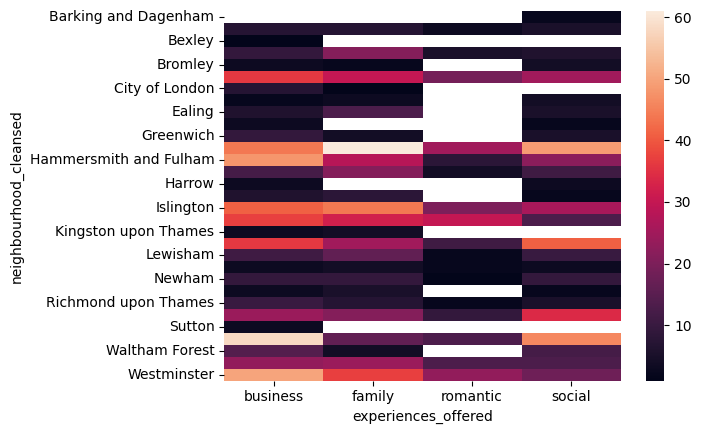

In [42]:
sns.heatmap(d_test.pivot(columns='experiences_offered', index='neighbourhood_cleansed', values='experiences_count'))

Выгрузите данные о ценах за ночь для разных типов жилья, для которых также доступен какой-либо вид впечатления. Необходимые для составления запроса столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь 
experiences_offered – вид доступного впечатления (оставить не 'none')
Пример части результирующей таблицы:

+-----------------+------------+
| room_type       | price_corr |
+-----------------+------------+
| Private room    |         65 |
| Entire home/apt |        100 |
| Entire home/apt |        ... |
+-----------------+------------+
Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн [$,] чтобы избавиться от $ и запятых; toFloat32OrNull(столбец)

Далее постройте два графика, используя distplot из библиотеки seaborn:

На первом отобразите исходные распределения цен для каждого типа жилья
На втором – логарифмированные значения (np.log())

In [77]:
g = '''
SELECT
room_type,
toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) as price
FROM
ldn_listings
where experiences_offered not like 'none'
'''

In [78]:
g_test = ph.read_clickhouse(query=g, connection=connection_default)
g_test

,room_type,price
0,Private room,65.0
1,Entire home/apt,100.0
2,Private room,150.0
3,Private room,45.0
4,Private room,25.0
...,...,...
1543,Entire home/apt,100.0
1544,Entire home/apt,125.0
1545,Entire home/apt,185.0
1546,Entire home/apt,110.0


C:\Users\Banana\AppData\Local\Temp\ipykernel_7156\4218985289.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(g_test.query("room_type =='Private room'").price, kde=False, label='Private room')
C:\Users\Banana\AppData\Local\Temp\ipykernel_7156\4218985289.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  

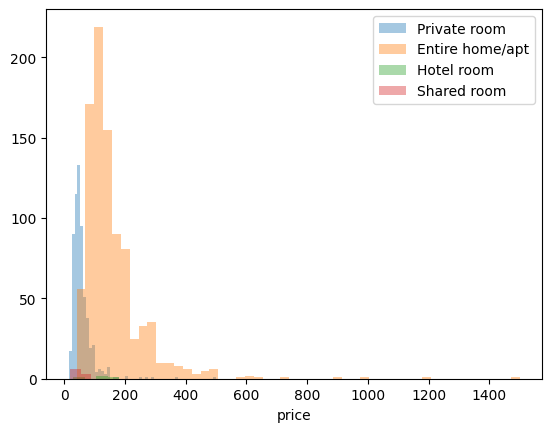

In [79]:
sns.distplot(g_test.query("room_type =='Private room'").price, kde=False, label='Private room')
sns.distplot(g_test.query("room_type =='Entire home/apt'").price, kde=False, label='Entire home/apt')
sns.distplot(g_test.query("room_type =='Hotel room'").price, kde=False, label='Hotel room')
sns.distplot(g_test.query("room_type =='Shared room'").price, kde=False, label='Shared room')
plt.legend()
plt.show()

C:\Users\Banana\AppData\Local\Temp\ipykernel_7156\276476134.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.log(g_test.query("room_type =='Private room'").price), kde=False, label='Private room')
C:\Users\Banana\AppData\Local\Temp\ipykernel_7156\276476134.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe57

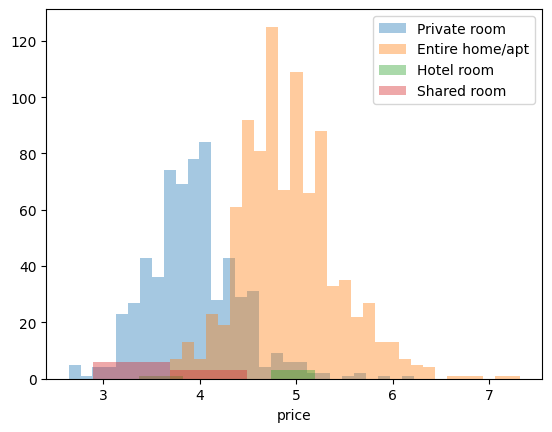

In [80]:
sns.distplot(np.log(g_test.query("room_type =='Private room'").price), kde=False, label='Private room')
sns.distplot(np.log(g_test.query("room_type =='Entire home/apt'").price), kde=False, label='Entire home/apt')
sns.distplot(np.log(g_test.query("room_type =='Hotel room'").price), kde=False, label='Hotel room')
sns.distplot(np.log(g_test.query("room_type =='Shared room'").price), kde=False, label='Shared room')
plt.legend()
plt.show()

Выгрузите данные о цене, типе жилья и дате первого отзыва, начиная со 2 января 2010 года. Необходимые столбцы:

room_type – тип сдаваемого жилья (доступные варианты: Entire home/apt, Private room, Hotel room, Shared room)
price – цена за ночь
first_review – дата первого отзыва (отфильтровать по правилу "строго больше 2010-01-01")
Ограничение поставьте на 1000 строк.

Hint: replaceRegexpAll(столбец, что_заменить, на_что_заменить) – паттерн [$,] чтобы избавиться от $ и запятых; toFloat32OrNull(столбец)

Пример результирующей таблицы:

+-----------------+------------+------------+
| room_type       | price_corr |first_review|
+-----------------+------------+------------+
| Private room    |         65 | 2010-03-23 |
| Entire home/apt |        100 | 2012-01-01 |
+-----------------+------------+------------+
Используя библиотеку seaborn и функцию lineplot, постройте график динамики средних цен на жилье (ось Y) в зависимости от типа комнаты (цвет линии, параметр 'hue') по годам (ось X). Датафрейм должен быть отсортирован по годам.

Пример датафрейма, который будет служить основой для графика:

+-----------------+------------+------------+
| room_type       | avg_price  | year       |
+-----------------+------------+------------+
| Private room    |         54 | 2010       |
| Entire home/apt |        168 | 2012       |
+-----------------+------------+------------+
Hints: line plot; удалите последние 6 символов у значений в столбце даты, чтобы получить год, например, с помощью применения lambda-функции .

In [129]:
b = '''
SELECT
room_type,
toFloat32OrNull(replaceRegexpAll(price, '[$,]','')) as price,
YEAR(toDateOrNull(first_review)) as year
from
ldn_listings
where first_review > '2010-01-01'
limit 1000
'''

In [130]:
b_test = ph.read_clickhouse(query=b, connection=connection_default)
b_test

,room_type,price,year
0,Private room,65.0,2010
1,Entire home/apt,300.0,2011
2,Entire home/apt,65.0,2016
3,Private room,29.0,2010
4,Private room,100.0,2010
...,...,...,...
995,Private room,45.0,2012
996,Private room,51.0,2013
997,Entire home/apt,79.0,2012
998,Entire home/apt,110.0,2012


<Axes: xlabel='year', ylabel='price'>

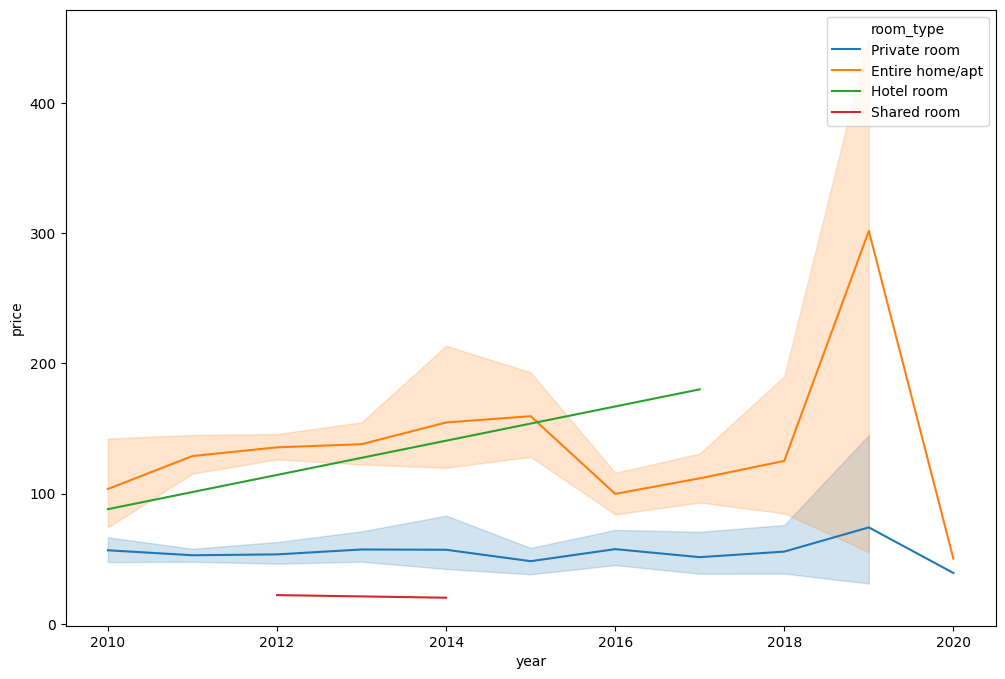

In [132]:
plt.figure(figsize=(12, 8))
sns.lineplot(x='year',y='price',hue='room_type',data=b_test)